In [1]:
import numpy as np
import TensorFrost as tf
import matplotlib.pyplot as plt

tf.initialize(tf.opengl)

inverse = False

def FFT():
    N = 1024
    RADIX2 = 10
    A = tf.input([N, 2], tf.float32)
    BK = 512

    def expi(angle):
        return tf.cos(angle), tf.sin(angle)

    def cmul(a, b):
        return a[0] * b[0] - a[1] * b[1], a[0] * b[1] + a[1] * b[0]

    def radix2(temp, span, index, inverse):
        group_size = span << 1
        group_half_mask = span - 1
        group_offset = index & group_half_mask
        group_index = (index - group_offset) << 1
        k1 = group_index + group_offset
        k2 = k1 + span

        d = 1.0 if inverse else -1.0
        angle = 2 * np.pi * d * tf.float(group_offset) / tf.float(group_size)

        #radix2 butterfly
        v1 = temp[2*k1], temp[2*k1 + 1]
        v2 = cmul(expi(angle), (temp[2*k2], temp[2*k2 + 1]))
        temp[2*k1] = v1[0] + v2[0]
        temp[2*k1 + 1] = v1[1] + v2[1]
        temp[2*k2] = v1[0] - v2[0]
        temp[2*k2 + 1] = v1[1] - v2[1]

    #2d local + group tiled version
    with tf.kernel([N], group_size=[BK]) as group_index:
        temp = tf.group_buffer(N*2, tf.float32)
        tx = group_index.block_thread_index(0)
        
        M = N // BK

        for i in range(M):
            rowIndex = i * BK + tx
            idx = tf.int(tf.reversebits(tf.uint(rowIndex)) >> (32 - RADIX2))
            temp[2*idx] = A[rowIndex, 0]
            temp[2*idx + 1] = A[rowIndex, 1]

        tf.group_barrier()

        span = 1
        while span < N:
            for j in range(M // 2):
                rowIndex = j * BK + tx
                radix2(temp, span, rowIndex, inverse)
            tf.group_barrier()
            span *= 2

        for i in range(M):
            rowIndex = i * BK + tx
            A[rowIndex, 0] = temp[2*rowIndex] / float(N if inverse else 1)
            A[rowIndex, 1] = temp[2*rowIndex + 1] / float(N if inverse else 1)

    return A

fft = tf.compile(FFT)

TensorFrost module loaded!
FFT:
  Kernel count: 1
  Intermediate buffers: 0
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 542
  IR Compile time: 11.146700 ms
  Codegen time: 1.679300 ms
  Host Compile time: 1387.222168 ms
  Shader Compile time: 44.394798 ms



In [2]:
all_kernels = tf.get_all_generated_kernels()
print("Generated kernels:")
for k in all_kernels:
    print(k[0][2])

Generated kernels:
shared float temp[2048];

layout (local_size_x = 512, local_size_y = 1, local_size_z = 1) in;

void main() {
  int block_id = int(gl_WorkGroupID.x + var._kernel_block_offset);
  int block_thread_id0 = int(gl_LocalInvocationID.x);
  int block_thread_id1 = int(gl_LocalInvocationID.y);
  int block_thread_id2 = int(gl_LocalInvocationID.z);

  int index_0 = (block_id * 512) + block_thread_id0;
  bool is_inside_dispatch = index_0 < 1024;
  if (is_inside_dispatch)
  {
    //float temp[2048]
    int tx = block_thread_id0;
    int idx = int(bitfieldReverse(uint(tx)) >> 22);
    float A = asfloat(A_mem[clamp(tx, 0, 1023) * 2]);
    temp[2 * idx] = A;
    float A_2 = asfloat(A_mem[(clamp(tx, 0, 1023) * 2) + 1]);
    temp[(2 * idx) + 1] = A_2;
    int rowIndex = 512 + tx;
    int idx_2 = int(bitfieldReverse(uint(rowIndex)) >> 22);
    float A_3 = asfloat(A_mem[clamp(rowIndex, 0, 1023) * 2]);
    temp[2 * idx_2] = A_3;
    float A_4 = asfloat(A_mem[(clamp(rowIndex, 0, 1023) * 2) 

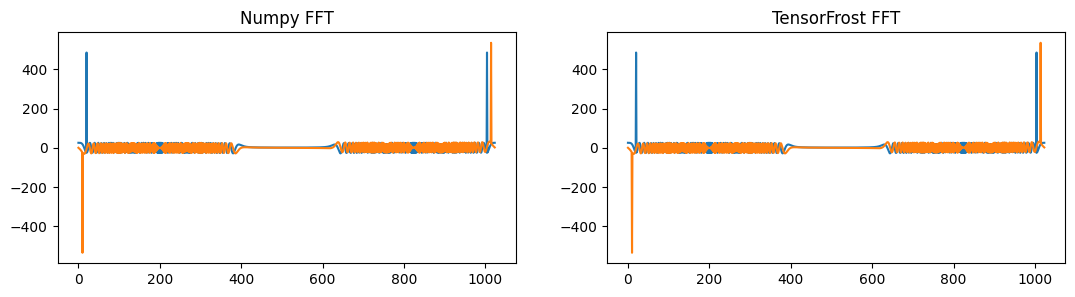

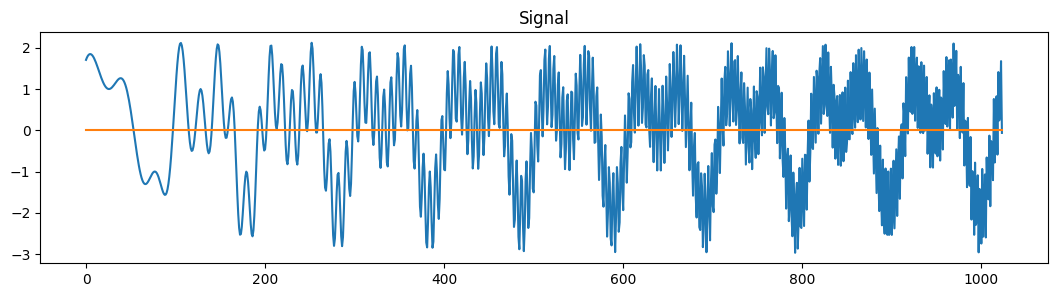

In [3]:
#test signal
N = 1024
t = np.arange(N)
signalre = np.sin(10 * 2 * np.pi * t / N).astype(np.float32)
signalre += np.cos(20 * 2 * np.pi * t / N)
signalre += np.sin(200 * 2 * np.pi * t * t / (N * N) + np.pi/4)

signalim = 0.0*np.cos(10 * 2 * np.pi * t / N).astype(np.float32)


#run the FFT
signal = np.zeros((N, 2), dtype=np.float32)
signal[:, 0] = signalre
signal[:, 1] = signalim
signal_tf = tf.tensor(signal)
Output_tf = fft(signal_tf)
output = Output_tf.numpy

#compare with numpy
np_fft = np.fft.fft(signalre + 1j * signalim)

#plot the results side by side
plt.figure(figsize=(13, 3))
plt.subplot(1, 2, 1)
plt.plot(np.real(np_fft), label="Real")
plt.plot(np.imag(np_fft), label="Imaginary")
plt.title("Numpy FFT")
plt.subplot(1, 2, 2)
plt.plot(output[:, 0], label="Real")
plt.plot(output[:, 1], label="Imaginary")
plt.title("TensorFrost FFT")
plt.show()

#plot signal
plt.figure(figsize=(13, 3))
plt.plot(signal)
plt.title("Signal")
plt.show()